In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/utils/plotUtils/histogram.py:154: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if scale is 'xs': scale = scale/lumi
/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/utils/plotUtils/histogram2d.py:109: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if scale is 'xs': scale = scale/lumi


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
signal = ObjIter([Tree(fn) for fn in fc.eightb.preselection_ranked_quadh.signal_list[::3]])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])
bkg = qcd + ttbar

In [4]:
def init_signal(tree):
  tree.color = None
signal.apply(init_signal)

[None, None, None]

In [5]:
(signal+bkg).apply(lambda t:build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

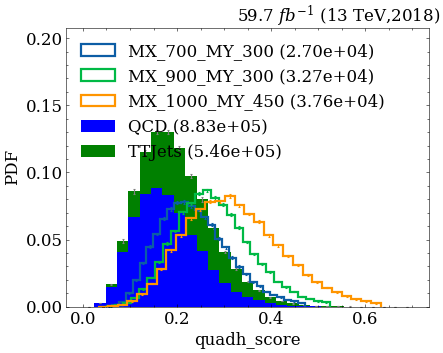

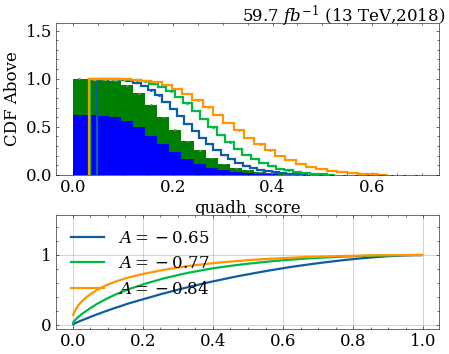

In [6]:
study.quick(
  signal+bkg, legend=True, stacked=True,
  varlist=['quadh_score'],
  binlist=[(0,0.7,30)],
  efficiency=True,
)

study.quick(
  signal+bkg, stacked=True,
  varlist=['quadh_score'],
  binlist=[(0,0.7,30)],
  cumulative=-1,
  correlation=True,
  c_label_stat='area',

)

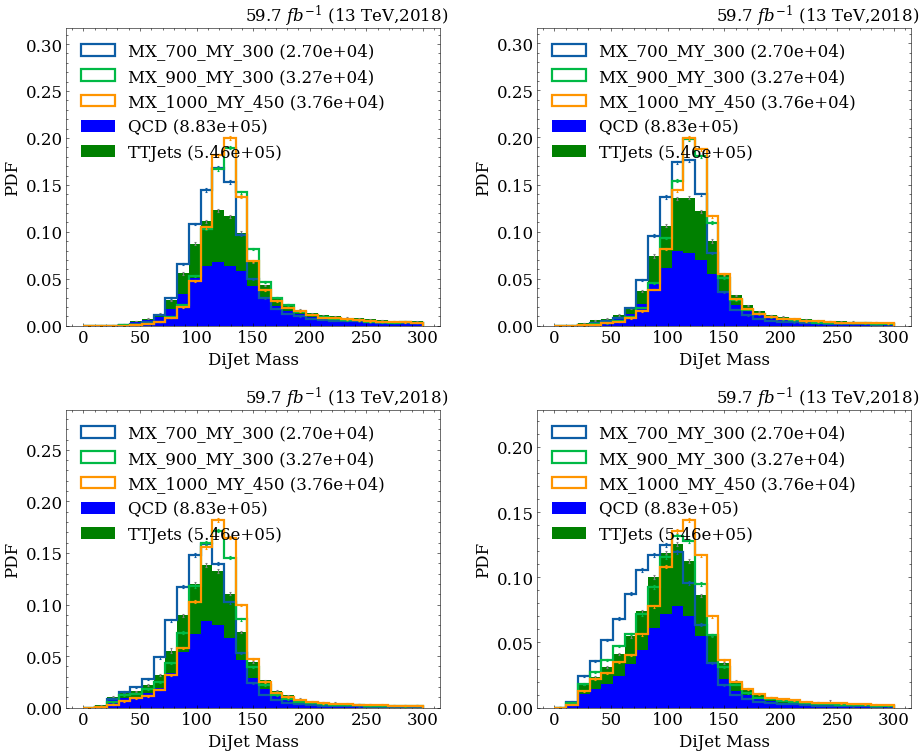

In [9]:
study.quick(
  signal+bkg, legend=True, stacked=True,
  varlist=[f'higgs_m[:,{i}]' for i,obj in enumerate(eightb.higgslist) ],
  # binlist=[(0,0.7,30)],
  efficiency=True,
)

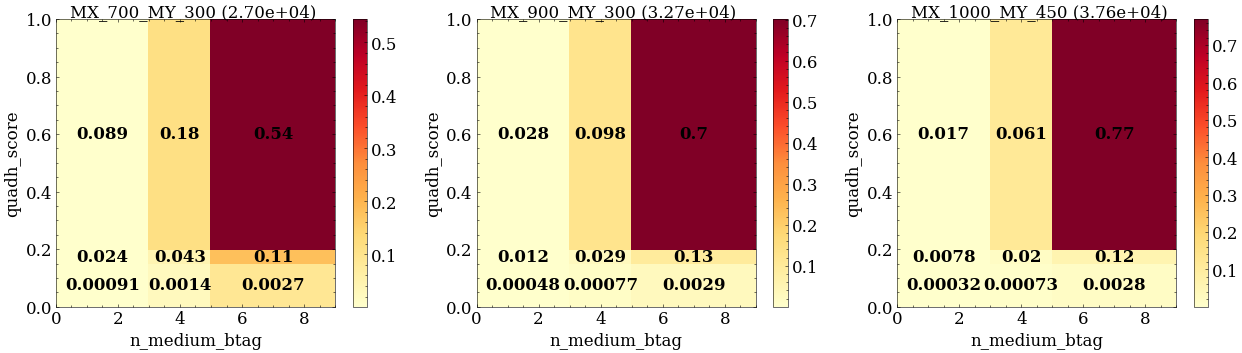

In [36]:

study.quick2d(
  signal,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[np.array((0,3,5,9)), np.array((0,0.15,0.2,1))],
  efficiency=True, show_counts=True,
  dim=(-1,3),
)

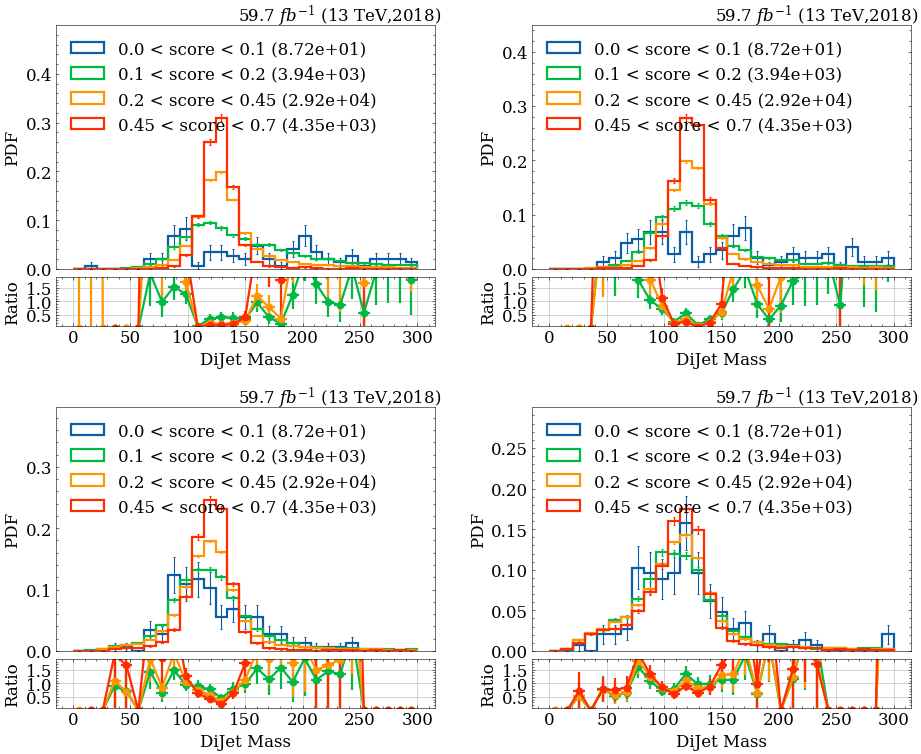

In [12]:
sections = [
  (0.,0.1),
  (0.1,0.2),
  (0.2,0.45),
  (0.45,0.7)
]

class quadh_section(ObjTransform):
  def __call__(self, t):
    return (t.quadh_score >=self.lo)&(t.quadh_score < self.hi)

masks = [ quadh_section(lo=s[0], hi=s[1], label=f'{s[0]} < score < {s[1]}') for s in sections ]
study.quick(
  signal[[-1]*len(sections)], stacked=True, label=[ mask.label for mask in masks ], legend=True,
  masks=masks,
  varlist=[f'higgs_m[:,{i}]' for i,obj in enumerate(eightb.higgslist) ],
  # binlist=[(0,0.7,30)],
  efficiency=True,
  # histo=False,

  ratio=True, 
  # r_group=[(0,3),(1,4),(2,5)]
)

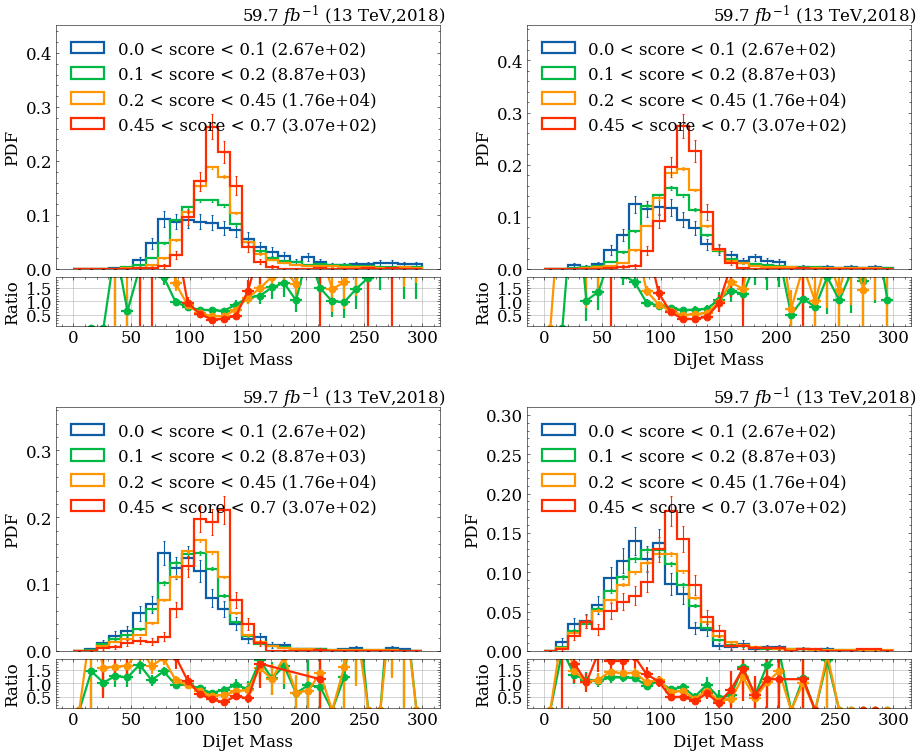

In [13]:

study.quick(
  signal[[0]*len(sections)], stacked=True, label=[ mask.label for mask in masks ], legend=True,
  masks=masks,
  varlist=[f'higgs_m[:,{i}]' for i,obj in enumerate(eightb.higgslist) ],
  # binlist=[(0,0.7,30)],
  efficiency=True,
  # histo=False,

  ratio=True, 
  # r_group=[(0,3),(1,4),(2,5)]
)

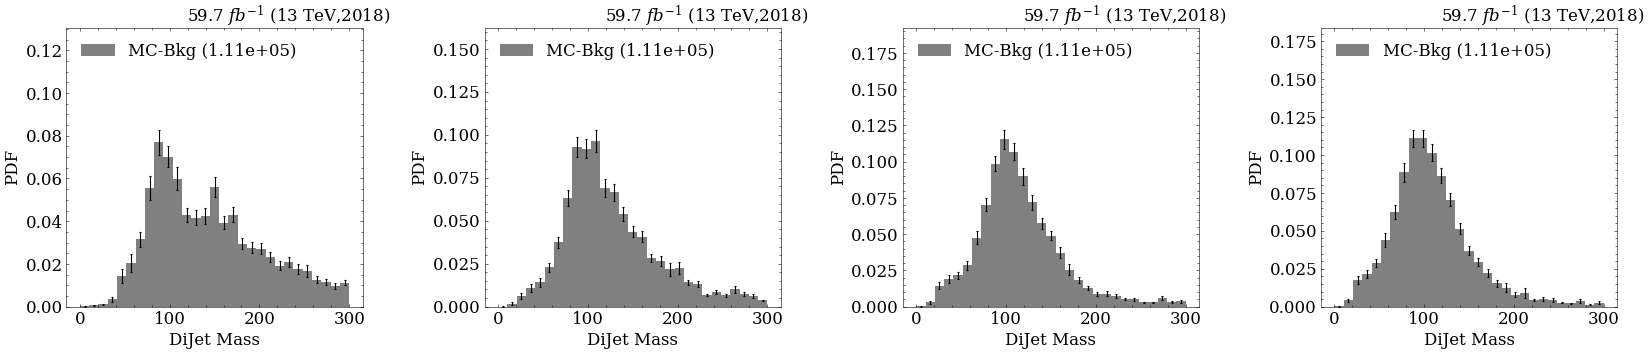

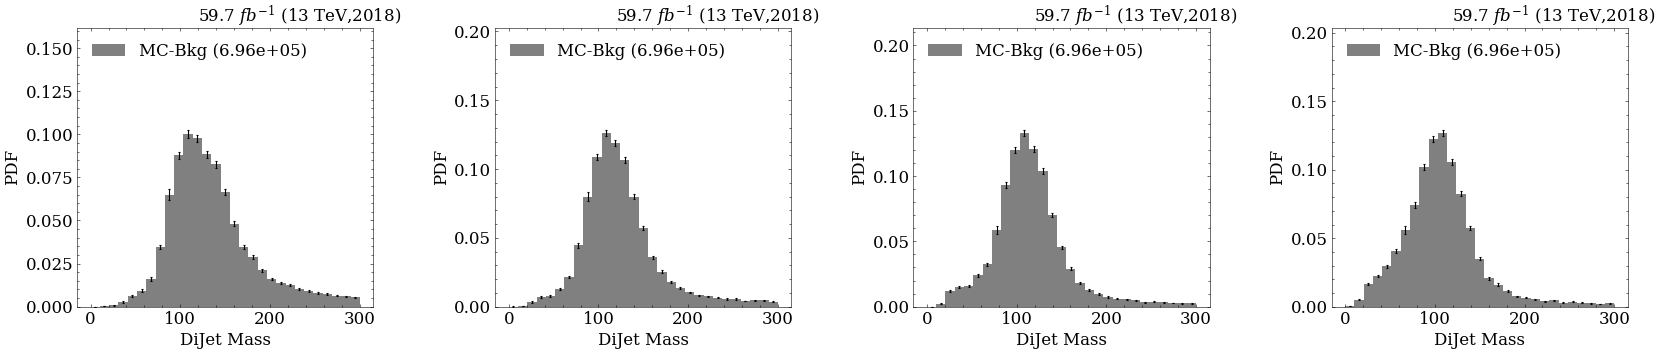

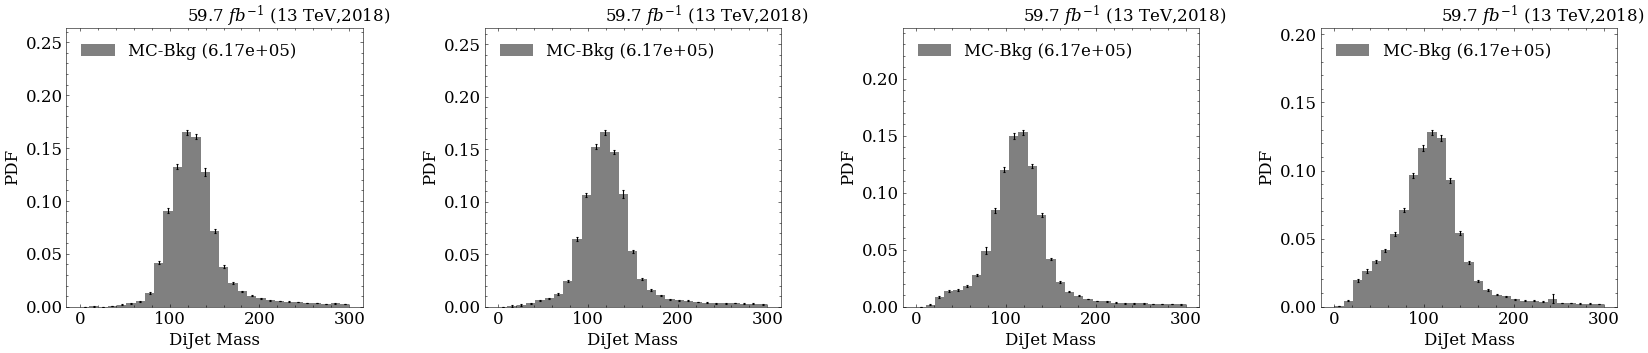

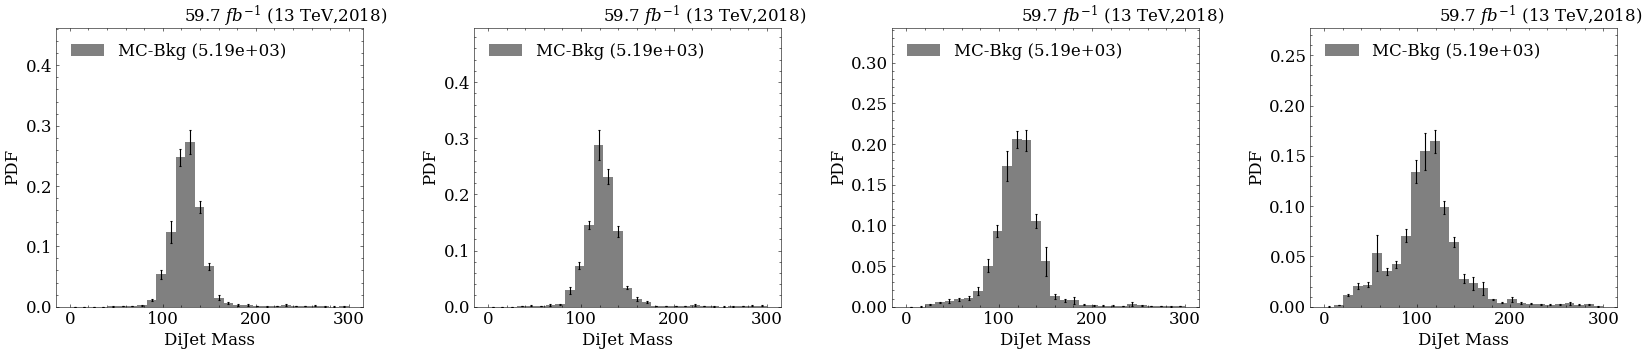

In [14]:
for mask in masks:
  study.quick(
    bkg, stacked=True, stack_fill=True, label=mask.label, legend=True,
    masks=mask,
  varlist=[f'higgs_m[:,{i}]' for i,obj in enumerate(eightb.higgslist) ],
    # binlist=[(0,0.7,30)],
    efficiency=True,
    dim=(-1,4),
    # histo=False,
  )

In [15]:
def plot_histo2d_x_corr(histo2d, fig, ax, **kwargs):
  corr = histo2d.x_corr(marker=None, fit='linear')
  ax.text(0.1,0.1,f'slope = {corr.fit.c1:0.2}',transform=ax.transAxes)
  plot_graph(corr, figax=(fig,ax), fill_error=True, xlim=ax.get_xlim(), ylim=ax.get_ylim())


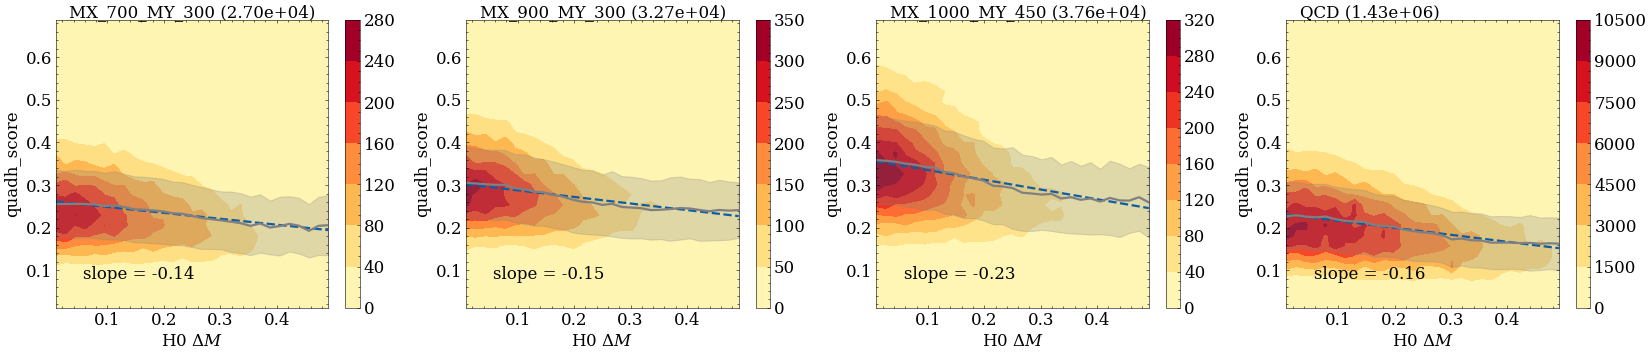

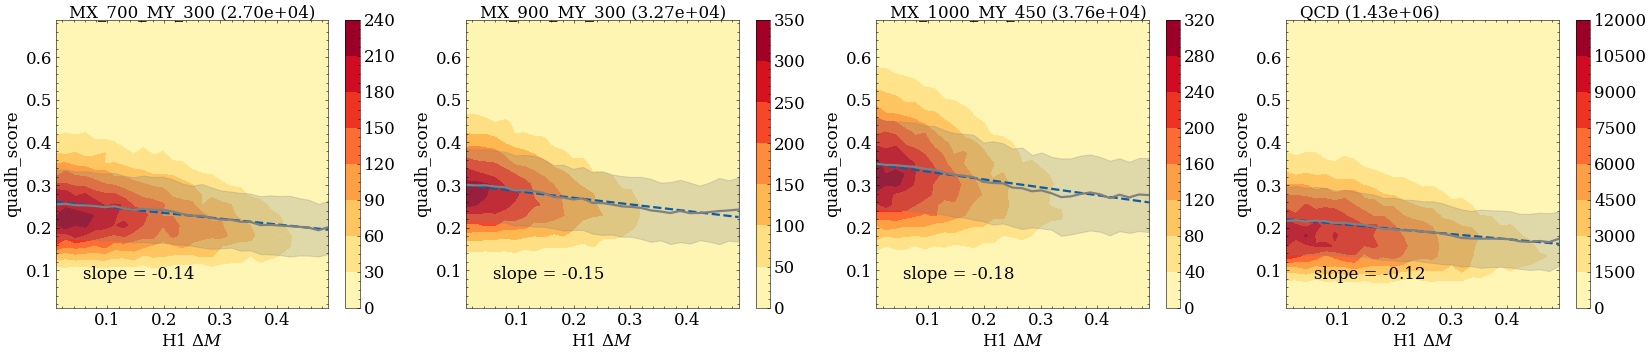

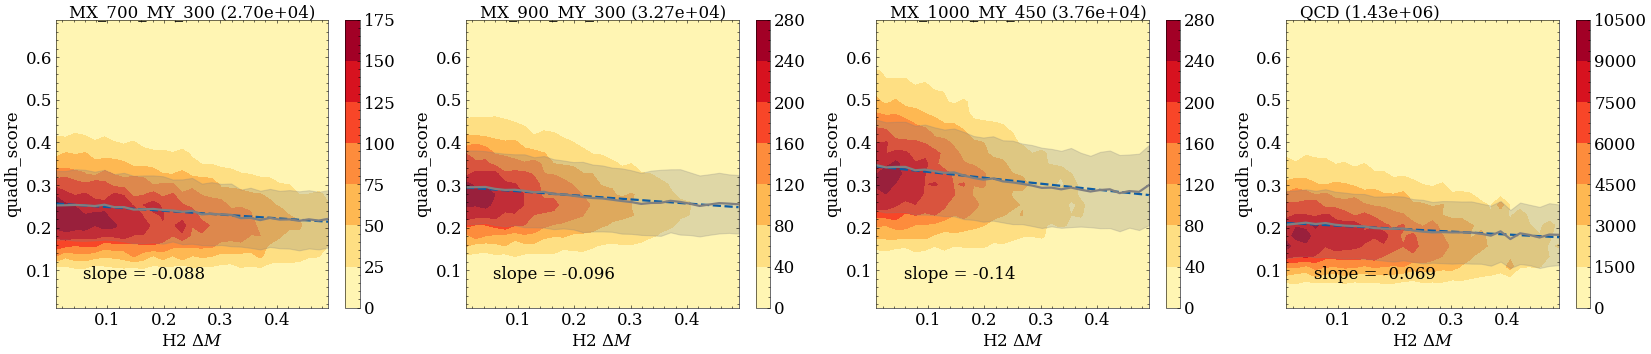

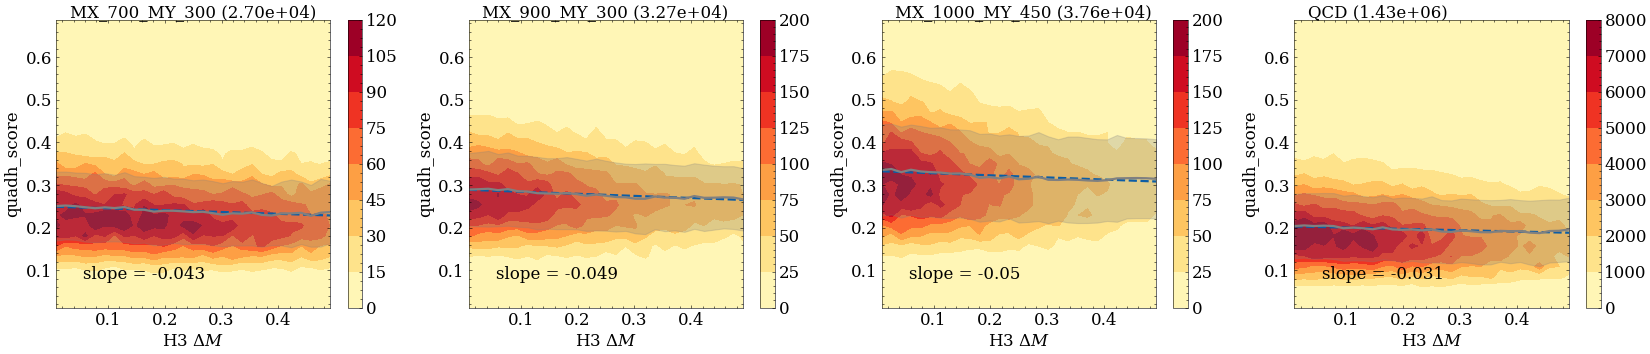

In [56]:
nbins=30

class higgs_dm(ObjTransform):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.xlabel = f'H{self.i} $\Delta M$'
    self.bins = (0,0.5,nbins)
  def __call__(self, t):
    return np.abs( t.higgs_m[:,self.i]-125 )/125

for h in range(4):
  fig,axs = study.quick2d(
    signal,
    varlist=[higgs_dm(i=h),'quadh_score'],
    binlist=[None,(0,0.7,nbins)],
    dim=(-1,4),
    exe=plot_histo2d_x_corr,
    contour=True,
    return_figax=True,
  )
  study.quick2d_region(
    bkg,
    varlist=[higgs_dm(i=h),'quadh_score'],
    binlist=[None,(0,0.7,nbins)],
    contour=True,
    exe=plot_histo2d_x_corr,
    figax=(fig,axs[-1])
  )

In [59]:
histo2d = Histo2D(signal[-1].H1Y1_m, signal[-1].Y2_m, x_bins=(0,250,100), y_bins=(200,1000,100))

(<Figure size 468x468 with 2 Axes>, <AxesSubplot:>)

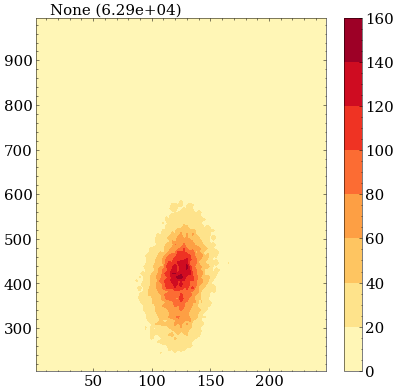

In [60]:
plot_histo2d(histo2d, contour=True)

4 2 2 4


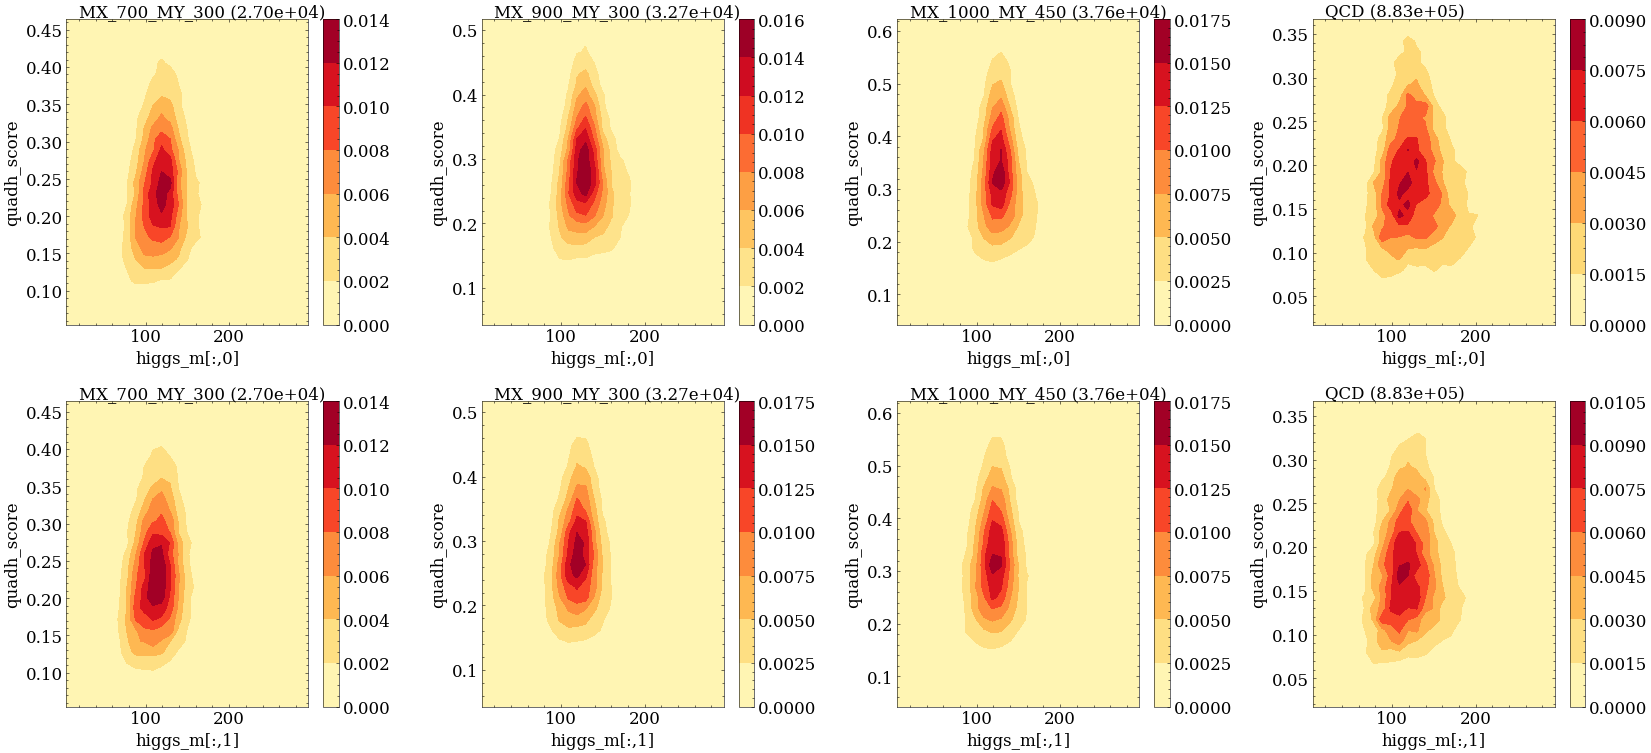

In [53]:
study.quick2d(
  signal+bkg[[0]],
  # varlist=['X_m','quadh_score'],
  xvarlist=[f'higgs_m[:,0]', 'higgs_m[:,1]'],
  yvarlist=['quadh_score']*2,
  dim=(-1,4),

  contour=True,
  # density=True,
  efficiency=True,
)